In [1]:
import pandas as pd
import glob
import json
import dotted # https://pypi.org/project/dotted-notation/
import re
import matplotlib.pyplot as plt
import json

from pathlib import Path
import seaborn as sns

In [2]:
import lib.datasciencetoolbelt as dstools
from lib.resultstorage import ResultStorage

In [3]:
#%matplotlib qt
%matplotlib inline

#  Dependencies

In [4]:
import itertools

def filter_by_index_value(df, level, filter):
    """Return a new df that only contains rows whose MultiIndex column `level`'s value passes `filter`"""
    return df[df.index.get_level_values(level).map(filter)]

def remove_index_dimension(df, level, value):
    """Reduce dimensionality of a dataframe by filtering by and subsequently dropping one of its index levels.
    
    df is assumed to be a multi-indexed pd.DataFrame.
    First, filter the data frame so that we only keep rows whose index tuple has value `value` at level `level`.
    Now the resulting data frame only has a single value at the level.
    Thus remove that level from the index.
    Voila: dimensionality reduced.
    """
    df = df[df.index.get_level_values(level) == value]
    assert set(df.index.get_level_values(level)) == {value}
    df.index = df.index.droplevel(level)
    return df

def _test_remove_index_dimension():
    data = [{"favnum": n, "favletter": l, "id": id} for id, (n, l) in enumerate(itertools.product([23,42],["a", "b"]))]
    d = pd.DataFrame(data).set_index(["favnum", "favletter"])
    display(d)
    display(remove_index_dimension(d, "favnum", 23))
    display(remove_index_dimension(d, "favletter", "b"))
    
_test_remove_index_dimension()

id
favnum favletter    
23     a           0
       b           1
42     a           2
       b           3

,id
favletter,
a,0
b,1


,id
favnum,
23,1
42,3


In [5]:
def level_values_sorted_unique(df, level):
    """Returns the sorted unique values of a DataFrame's multi-index at level `level`"""
    return sorted(list(set(df.index.get_level_values(level))))

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class FactorizedDataFrameItem(AttrDict):
    @property
    def title(self):
        if self.fdf.row and self.fdf.col:
            return f"{self.fdf.row}={self.rv}|{self.fdf.col}={self.cv}"
        elif self.fdf.row:
            return f"{self.fdf.row}={self.rv}"
        elif self.fdf.col:
            return f"{self.fdf.col}={self.cv}"
        else:
            return ""
            
        
class FactorizedDataFrame:
    def __init__(self, data, row, col):
        self.data = data
        self.col = col
        self.row = row

        self.col_values = [None] if not self.col else level_values_sorted_unique(self.data, self.col)
        self.row_values = [None] if not self.row else level_values_sorted_unique(self.data, self.row)
        
    def iter_factorized(self):
        for ci, c in enumerate(self.col_values):
            for ri, r in enumerate(self.row_values):
                d = self.data.copy()
                if c:
                    d = remove_index_dimension(d, self.col, c)
                if r:
                    d = remove_index_dimension(d, self.row, r)
                # display(d)
            
                context = FactorizedDataFrameItem({
                    "fdf": self,
                    "d": d,
                    "ri": ri,
                    "rv": r,
                    "ci": ci,
                    "cv": c,
                    "is_last_row": ri == len(self.row_values)-1,
                    "is_last_col": ci == len(self.col_values)-1,
                })
                yield context
                

def factorplot(data=None, row=None, col=None, plot=None, subplots_kw={}):
    """Factorizez MultiIndex'ed DataFrame `data`, then invokes `plot` for each FactorizedDataFrameItem"""
    
    fdf = FactorizedDataFrame(data, row, col)
    
    subplots_kw = {
        "gridspec_kw": {'hspace': 1},
        **subplots_kw,
        "squeeze": False, # axes should always be two-dimensional
    }

    fig, axes = plt.subplots(len(fdf.row_values), len(fdf.col_values), **subplots_kw)

    for f in fdf.iter_factorized():
        ax = axes[f.ri, f.ci]
        ax.set_title(f.title)
        legend = f.ri == len(fdf.row_values)-1 and f.ci == len(fdf.col_values)-1
        plot(f, ax, legend)
        if legend:
            plt.legend(loc='lower left', bbox_to_anchor=(1,0.5))

# End Dependencies

In [6]:
dstools.setup({
    "seaborn_context": "talk",
    "savefig": {
        "enable": True,
        "dir": Path("./postprocess_results"),
    }
})
result_storage = ResultStorage(Path("./results"))

In [7]:
id_vars__dottedpath_and_shortname_and_type = [
#     ('result.identity', "benchmark", str),  
#     ("storage_stack.identity", "storage_stack", str),
    ("result.fio_config.numjobs", "numjobs", int),
]
id_vars = [p[1] for p in id_vars__dottedpath_and_shortname_and_type]

def extract_id_var_values(output_json):
    d = output_json
    id_var_values = {}
    for dp, sn, ty in id_vars__dottedpath_and_shortname_and_type: 
        v = dotted.get(d, dp)
        if not v:
            raise Exception(f"{d['file']}: dotted path {dp} not found")
        if sn in id_var_values:
            raise Exception(f"duplicate shortname {sn}")
        try:
            id_var_values[sn] = ty(v)
        except ValueError as e:
            raise Exception(f"cannot parse v={v!r}") from e
    return id_var_values


def get_fio_write_metrics(output_json):
    d = output_json
    jobs = dotted.get(d, "fio_jsonplus.jobs")
    assert len(jobs) == 1
    j0 = jobs[0]
    jw = jobs[0]["write"]
    return {
        "w_iops_mean": jw["iops_mean"],
        "w_iops_stddev": jw["iops_stddev"],
        "w_lat_mean": dotted.get(jw, "lat_ns.mean"),
        "w_lat_stddev": dotted.get(jw, "lat_ns.stddev"),
    }


def to_row_dict(output_json):
    try:
        r = {}
        for k, v in dotted.get(output_json, "result.latency_analysis").items():
            assert k[0] == '@'
            k = k[1:] # strip leading @
            assert k not in r
            r[k] = v

        r = {
            **extract_id_var_values(output_json),
            "fio_metrics": get_fio_write_metrics(output_json['result']),
            **r,
        }
        return r
    except:
        print(json.dumps(output_json))
        raise

rows = [to_row_dict(j) for j in result_storage.iter_results("zillwb_latency_analysis__v2")]

In [8]:
df = pd.DataFrame.from_dict(rows)
df = df.set_index(id_vars)
df = df.sort_index()
display(df)
# display(df / 1_000_000)
# compute zfs write breakdown

,fio_metrics,zfs_write,zfs_write_count,zil_commit,zfs_log_write_begin,zfs_log_write_finish,zillwb_commit_waiter__issue,zillwb_commit_waiter__timeout,pmem_submit_bio
numjobs,,,,,,,,,
1,"{'w_iops_mean': 14557.157895, 'w_iops_stddev':...",934966807,14723,721962424,13223612,9654285,485676076,77781397,111833172
2,"{'w_iops_mean': 32096.631579, 'w_iops_stddev':...",1804713184,28964,1359388190,29438810,26144633,831294308,149250400,199945251
3,"{'w_iops_mean': 50796.736842, 'w_iops_stddev':...",3007935281,47512,2260313645,49330625,40906361,1343446930,243415109,322664207
4,"{'w_iops_mean': 61683.684211, 'w_iops_stddev':...",3612482097,49767,2735108788,57238706,47744196,1532371331,286272147,362578546
5,"{'w_iops_mean': 68240.736842, 'w_iops_stddev':...",4269469785,55814,3237634607,67953230,56988481,1787508545,328057062,442837254
6,"{'w_iops_mean': 76688.052632, 'w_iops_stddev':...",5417307866,67536,4107219927,87452227,70961748,2334002838,422976779,567849476
7,"{'w_iops_mean': 83502.315789, 'w_iops_stddev':...",4498014713,51019,3472650075,67821542,54726853,1896559561,337736010,448062063
8,"{'w_iops_mean': 80617.684211, 'w_iops_stddev':...",7123262912,76945,5498397344,108239607,88076870,3214789173,551845679,715909768


In [9]:
df.columns

Index(['fio_metrics', 'zfs_write', 'zfs_write_count', 'zil_commit',
       'zfs_log_write_begin', 'zfs_log_write_finish',
       'zillwb_commit_waiter__issue', 'zillwb_commit_waiter__timeout',
       'pmem_submit_bio'],
      dtype='object')

In [10]:
df_bak = df.copy()

In [11]:

# zfs_write = ASYNC + zfs_log_write_{begin,end} + zil_commit
# zil_commit = ZIL_LWB_OTHER +  zillwb_commit_waiter__timeout  + zillwb_commit_waiter__issue
# zillwb_commit_waiter__issue = ZIL_LWB_ZIOWAIT + pmem_submit_bio
df["zio"] = df.zillwb_commit_waiter__issue - df.pmem_submit_bio
df["zil-lwb-other"] = df.zil_commit - df.zillwb_commit_waiter__timeout - df.zillwb_commit_waiter__issue
df["itx"] = df.zfs_log_write_begin + df.zfs_log_write_finish
df["async"] = df.zfs_write - df.itx - df.zil_commit
# cosmetics
df["zil-lwb-fill-timeout"] = df.zillwb_commit_waiter__timeout
df["zil-lwb-ziowait"] = df.zillwb_commit_waiter__issue - df.pmem_submit_bio

# df["pmem"] = df["pmem_submit_bio"]
# # df["zio"] = df["zio_rewrite"] - df["pmem"]
# df["zil-lwb-fill-timeout"] = df["zillwb_commit_waiter__timeout"]
# df["zil-lwb-ziowait"] = df["zillwb_commit_waiter__issue"]
# df["zil-lwb-other"] = df["zil_commit"] - df["zil-lwb-ziowait"] - df["zil-lwb-fill-timeout"]
# df["itx"] = df["zfs_log_write_begin"] + df["zfs_log_write_finish"]
# df["async"] = df["zfs_write"] - (df["itx"] + df[""])

df["zfs_write__lat_avg"] = df["zfs_write"] / df["zfs_write_count"]
display(df.zfs_write__lat_avg)


# zfs_write_comps = ["async", "itx", "zil", "zio", "pmem"]
zfs_write_comps = [ "async", "itx", "zil-lwb-other", "zil-lwb-fill-timeout", "zil-lwb-ziowait", "pmem_submit_bio"]

# add `unaccounted` component
tmp = df.filter(zfs_write_comps, axis=1)
# display(tmp)
tmp = tmp.transpose().sum()
# display(tmp)
df["unaccounted"] = df["zfs_write"] - tmp
zfs_write_comps += ["unaccounted"]

# relative breakdown (the raw data is aggregate wall-clock time spent in the functions,
# not-so-precise cpaturing interval)

pdata = df.filter(zfs_write_comps, axis=1)
df_latbreakdown = pdata
display(df_latbreakdown)

numjobs
1    63503.824424
2    62308.838006
3    63308.959442
4    72587.901561
5    76494.603236
6    80213.632226
7    88163.521688
8    92576.033686
Name: zfs_write__lat_avg, dtype: float64

,async,itx,zil-lwb-other,zil-lwb-fill-timeout,zil-lwb-ziowait,pmem_submit_bio,unaccounted
numjobs,,,,,,,
1,190126486,22877897,158504951,77781397,373842904,111833172,0
2,389741551,55583443,378843482,149250400,631349057,199945251,0
3,657384650,90236986,673451606,243415109,1020782723,322664207,0
4,772390407,104982902,916465310,286272147,1169792785,362578546,0
5,906893467,124941711,1122069000,328057062,1344671291,442837254,0
6,1151673964,158413975,1350240310,422976779,1766153362,567849476,0
7,902816243,122548395,1238354504,337736010,1448497498,448062063,0
8,1428549091,196316477,1731762492,551845679,2498879405,715909768,0


In [12]:
tmp = df.copy()
df_fio = tmp['fio_metrics'].apply(pd.Series)
df_fio

,w_iops_mean,w_iops_stddev,w_lat_mean,w_lat_stddev
numjobs,,,,
1,14557.157895,3363.816570,67564.026097,159810.076995
2,32096.631579,1982.730465,61552.451861,265587.906733
3,50796.736842,2180.232132,58080.824819,227615.729893
4,61683.684211,2316.969613,63651.827995,233008.166604
5,68240.736842,2474.094343,71795.930255,317117.671491
6,76688.052632,2256.499303,76778.283540,260809.847613
7,83502.315789,2375.671358,82661.921494,298937.389051
8,80617.684211,2197.473090,96728.500466,246524.709962


# Relative Latency Breakdown

,async,itx,zil-lwb-other,zil-lwb-fill-timeout,zil-lwb-ziowait,pmem_submit_bio,unaccounted
numjobs,,,,,,,
1,0.203351,0.024469,0.169530,0.083192,0.399846,0.119612,0.0
2,0.215958,0.030799,0.209919,0.082700,0.349833,0.110791,0.0
3,0.218550,0.030000,0.223892,0.080924,0.339363,0.107271,0.0
4,0.213812,0.029061,0.253694,0.079245,0.323820,0.100368,0.0
5,0.212414,0.029264,0.262812,0.076838,0.314950,0.103722,0.0
6,0.212592,0.029242,0.249246,0.078079,0.326020,0.104821,0.0
7,0.200714,0.027245,0.275311,0.075086,0.322030,0.099613,0.0
8,0.200547,0.027560,0.243114,0.077471,0.350805,0.100503,0.0


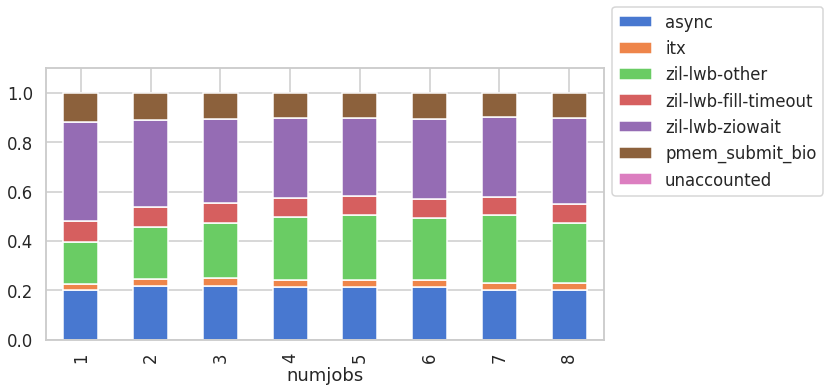

In [13]:
data = df_latbreakdown.copy()
total = data.sum(axis=1)
data = data.div(total, axis=0)
# display(data)

def plot(f, ax, legend):
    f.d.plot.bar(ax=ax, ylim=(0, 1.1), legend=False, stacked=True)
    if not f.is_last_row:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
    
factorplot(data, row=None, col=None, plot=plot, subplots_kw={
    "figsize": (10,5),
#     "gridspec_kw": {'hspace': 0.2},
})

display(data)

# Absolute Latency Normalized By IOPS

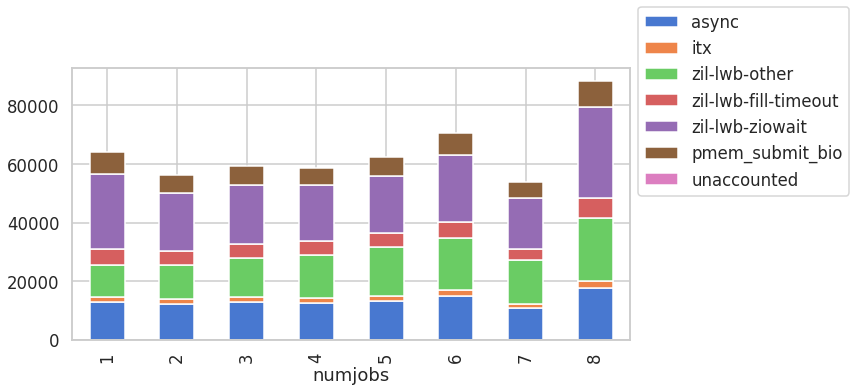

In [14]:
data = df_latbreakdown.div(df_fio.w_iops_mean, axis=0)
#data = df_latbreakdown

def plot(f, ax, legend):
    f.d.plot.bar(ax=ax, ylim=(0, None), legend=legend, stacked=True)
    if not f.is_last_row:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
    
factorplot(data, row=None, col=None, plot=plot, subplots_kw={
    "figsize": (10, 5),
    "gridspec_kw": {'hspace': 0.2},
})

<AxesSubplot:xlabel='numjobs'>

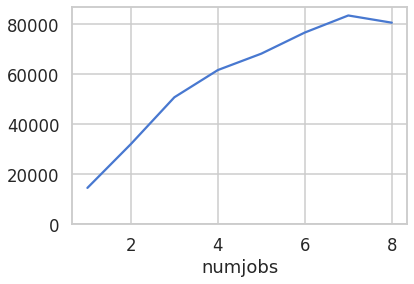

In [15]:
# for reference
df_fio.w_iops_mean.plot(ylim=(0, None))